# utils

In [7]:
import importlib
import generatePopulation
importlib.reload(generatePopulation)
filepath = "data/E-n32-k6-s7-edited.evrp"
evrp_data = generatePopulation.parse_evrp_file(filepath)
population = generatePopulation.generate_initial_population(evrp_data)



In [8]:
print("=== Data EVRP ===")
print(f"Depot: {evrp_data['depot']}")
print(f"Customers: {evrp_data['customers']}")
print(f"Stations: {evrp_data['stations']}")
print(f"Total Vehicles: {evrp_data['vehicles']}")
print(f"Capacity: {evrp_data['capacity']}")
print(f"Energy Capacity: {evrp_data['energy_capacity']}")
print("\n=== Initial Population Sample ===")

for i, chromosome in enumerate(population[:5]):
    print(f"Chromosome {i+1}: {chromosome}")

=== Data EVRP ===
Depot: [1, 31, 32]
Customers: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Stations: [24, 25, 26, 27, 28, 29, 30]
Total Vehicles: 6
Capacity: 4500
Energy Capacity: 162

=== Initial Population Sample ===
Chromosome 1: [1, 11, 2, 10, 1, '|', 31, 16, 30, 30, 9, 25, 12, 31, '|', 32, 22, 6, 25, 3, 32, '|', 1, 23, 29, 20, 8, 1, '|', 31, 7, 26, 19, 21, 31, '|', 32, 25, 4, 28, 14, 5, 25, 25, 18, 30, 15, 17, 13, 32]
Chromosome 2: [1, 12, 10, 25, 17, 1, '|', 31, 20, 27, 4, 2, 31, '|', 32, 25, 16, 30, 6, 25, 13, 32, '|', 1, 3, 28, 28, 22, 24, 11, 1, '|', 31, 19, 27, 7, 26, 26, 5, 25, 31, '|', 32, 25, 18, 30, 14, 26, 26, 21, 29, 23, 29, 15, 9, 25, 8, 32]
Chromosome 3: [1, 8, 25, 25, 23, 29, 7, 1, '|', 31, 4, 3, 15, 31, '|', 32, 5, 25, 25, 16, 30, 20, 32, '|', 1, 14, 2, 28, 6, 1, '|', 31, 30, 22, 24, 11, 26, 21, 31, '|', 32, 19, 27, 17, 9, 25, 13, 26, 26, 18, 30, 10, 12, 32]
Chromosome 4: [1, 7, 21, 29, 29, 22, 24, 1, '|', 31, 13, 2, 17, 31, '|'

In [38]:
def get_type(node):
    if node in evrp_data['depot']:
        return 'D'
    elif node in evrp_data['customers']:
        return 'C'
    elif node in evrp_data['stations']:
        return 'S'
    else:
        return 'U'  # Unknown

In [9]:
evrp_data['coords'][1]

(266.0, 235.0)

In [42]:
#create distance matrix (with proper indexing)
distance_matrix = []
for i in range(1, len(evrp_data['coords'])+1):
    temp = []
    for j in range(1, len(evrp_data['coords'])+1):
        if i == j:
            temp.append(0.0)
        else:
            xi, yi = evrp_data['coords'][i]
            xj, yj = evrp_data['coords'][j]
            dist = ((xi - xj) ** 2 + (yi - yj) ** 2) ** 0.5
            temp.append(dist)
    distance_matrix.append(temp)
    
print(f"Distance matrix size: {len(distance_matrix)} x {len(distance_matrix[0])}")

Distance matrix size: 32 x 32


In [11]:
def fitness_function(chromosome, distance_matrix, evrp_data,
					 battery_capacity=162, consumption_rate=1.0, charging_rate=1.0,
					 w1=0.6, w2=0.4):
	"""Compute fitness for a chromosome.

	Parameters
	- chromosome: list of genes with '|' separators between routes
	- distance_matrix: distance matrix (0-indexed internally)
	- evrp_data: EVRP data with stations and depot info

	Returns: lower is better
	"""
	total_distance = 0.0
	total_charging_time = 0.0
	invalid_penalty = 1e6
	
	# Helper to get distance
	def get_dist(a, b):
		# Adjust for 0-indexed distance_matrix (nodes are 1-indexed)
		return distance_matrix[a-1][b-1]
	
	stations = evrp_data['stations']
	depot = evrp_data['depot']
	
	# Parse chromosome into routes
	routes = []
	current = []
	for gene in chromosome:
		if gene == '|':
			if current:
				routes.append(current)
				current = []
		else:
			current.append(gene)
	if current:
		routes.append(current)
	
	# Evaluate each route
	for route in routes:
		battery = battery_capacity
		
		for i in range(len(route) - 1):
			a, b = route[i], route[i+1]
			dist = get_dist(a, b)
			total_distance += dist
			needed_energy = dist * consumption_rate

			# BEFORE consuming energy, check if current node is a charging station
			if a in stations:
				# At charging station - calculate how much to charge
				# Look ahead to find energy needed until next station/depot
				energy_needed_ahead = 0.0
				for j in range(i, len(route) - 1):
					u, v = route[j], route[j+1]
					energy_needed_ahead += get_dist(u, v) * consumption_rate
					# Stop at next station or depot
					if v in stations or v in depot:
						break
				
				# Charge only what we need (greedy charging)
				required_energy = max(0.0, energy_needed_ahead - battery)
				if required_energy > 0:
					charge_time = required_energy / charging_rate if charging_rate > 0 else 0.0
					total_charging_time += charge_time
					battery = min(battery + required_energy, battery_capacity)
			
			# Now consume energy for this segment
			if battery < needed_energy - 1e-9:  # small tolerance for floating point
				return invalid_penalty
			battery -= needed_energy

	D = total_distance / 100.0
	C = total_charging_time / 100.0
	fitness = w1 * D + w2 * C
	return fitness

In [12]:
fitness=[]
for chrom in population:
    fit = fitness_function(chrom, distance_matrix,evrp_data=evrp_data)
    fitness.append(fit)

In [13]:
fitness

[11.623085426688519,
 14.771868796943098,
 14.075705131357138,
 11.627181121940266,
 12.86204337285127,
 14.364737316701392,
 14.152451821786897,
 16.072835849277,
 14.838082897088496,
 11.534764422368065]

In [14]:
def viz_route(chromosome):
    import matplotlib.pyplot as plt
    
    # Parse chromosome to extract routes
    routes = []
    current_route = []
    
    for gene in chromosome:
        if gene == '|':
            if current_route:
                routes.append(current_route)
                current_route = []
        else:
            # Convert gene to node index
            if isinstance(gene, str):
                if gene.startswith('D'):
                    node_idx = int(gene[1:])
                elif gene.startswith('C'):
                    node_idx = int(gene[1:])
                elif gene.startswith('S'):
                    node_idx = int(gene[1:])
            else:
                node_idx = gene
            current_route.append(node_idx)
    
    if current_route:
        routes.append(current_route)
    
    # Create plot
    plt.figure(figsize=(12, 8))
    
    # Plot depots (can be multiple)
    depot_nodes = evrp_data['depot'] if isinstance(evrp_data['depot'], list) else [evrp_data['depot']]
    for depot_idx in depot_nodes:
        depot_x, depot_y = evrp_data['coords'][depot_idx]
        plt.scatter(depot_x, depot_y, c='red', s=200, marker='s', label='Depot' if depot_idx == depot_nodes[0] else '', zorder=5)
    
    # Plot customers
    for customer in evrp_data['customers']:
        cx, cy = evrp_data['coords'][customer]
        plt.scatter(cx, cy, c='blue', s=100, marker='o', label='Customer' if customer == evrp_data['customers'][0] else '', zorder=3)
    
    # Plot stations
    for station in evrp_data['stations']:
        sx, sy = evrp_data['coords'][station]
        plt.scatter(sx, sy, c='green', s=150, marker='^', label='Station' if station == evrp_data['stations'][0] else '', zorder=4)
    
    # Plot routes with different colors
    import numpy as np
    colors = plt.cm.tab10(np.linspace(0, 1, len(routes)))
    
    for i, route in enumerate(routes):
        route_x = []
        route_y = []
        
        for node in route:
            x, y = evrp_data['coords'][node]
            route_x.append(x)
            route_y.append(y)
        
        # Plot route line
        plt.plot(route_x, route_y, c=colors[i], linewidth=2, alpha=0.7, label=f'Route {i+1}')
        
        # Add arrows to show direction
        for j in range(len(route_x) - 1):
            dx = route_x[j+1] - route_x[j]
            dy = route_y[j+1] - route_y[j]
            if abs(dx) > 0.1 or abs(dy) > 0.1:  # Only draw arrow if there's significant movement
                plt.arrow(route_x[j], route_y[j], dx*0.3, dy*0.3, 
                         head_width=2, head_length=2, fc=colors[i], ec=colors[i], alpha=0.5)
    
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Vehicle Routes Visualization')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


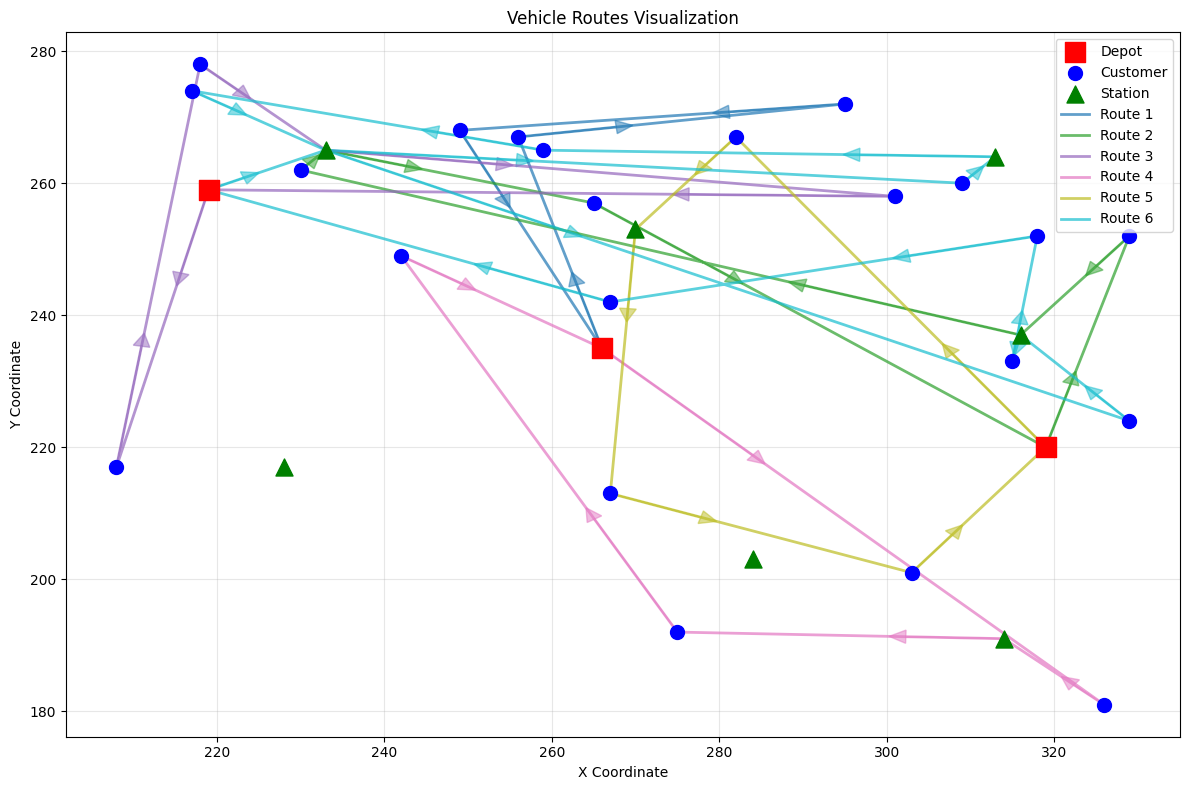

In [15]:
viz_route(population[0])

# Genetic Algorithm Configuration & Main Loop

**Best Practice Flow:**
1. **Initialize**: Generate initial population
2. **Evaluate**: Calculate fitness for all chromosomes
3. **Loop** (untuk N generasi):
   - **Selection**: Pilih parents menggunakan tournament selection
   - **Crossover**: Generate offspring dari parents (dengan crossover rate)
   - **Mutation**: Mutasi offspring (dengan mutation rate)
   - **Evaluate**: Hitung fitness offspring baru
   - **Replacement**: Gabung population lama + offspring, pilih yang terbaik (elitism)
4. **Result**: Return best chromosome

**Parameter yang digunakan:**
- Population Size: 10
- Elite Size: 2 (top 20% dipertahankan)
- Crossover Rate: 0.8 (80% parents akan di-crossover)
- Mutation Rate: 0.1 (10% offspring akan di-mutasi)
- Tournament Size: 3
- Max Generations: 50


In [70]:
# ===== GA PARAMETERS =====
POPULATION_SIZE = 10
ELITE_SIZE = 2  # Jumlah individu terbaik yang langsung lolos ke generasi berikutnya
CROSSOVER_RATE = 0.8  # Probabilitas melakukan crossover
MUTATION_RATE = 0.1  # Probabilitas melakukan mutation
TOURNAMENT_SIZE = 3  # Ukuran tournament untuk selection
MAX_GENERATIONS = 50
CONVERGENCE_THRESHOLD = 0.001  # Jika improvement < threshold selama N generasi, stop
CONVERGENCE_PATIENCE = 10  # Berapa generasi tidak ada improvement sebelum stop

print("=== Genetic Algorithm Configuration ===")
print(f"Population Size: {POPULATION_SIZE}")
print(f"Elite Size: {ELITE_SIZE}")
print(f"Crossover Rate: {CROSSOVER_RATE}")
print(f"Mutation Rate: {MUTATION_RATE}")
print(f"Tournament Size: {TOURNAMENT_SIZE}")
print(f"Max Generations: {MAX_GENERATIONS}")
print(f"Convergence: {CONVERGENCE_PATIENCE} generations with improvement < {CONVERGENCE_THRESHOLD}")


=== Genetic Algorithm Configuration ===
Population Size: 10
Elite Size: 2
Crossover Rate: 0.8
Mutation Rate: 0.1
Tournament Size: 3
Max Generations: 50
Convergence: 10 generations with improvement < 0.001


In [ ]:
def genetic_algorithm(evrp_data, distance_matrix, 
                      pop_size=POPULATION_SIZE, 
                      elite_size=ELITE_SIZE,
                      crossover_rate=CROSSOVER_RATE, 
                      mutation_rate=MUTATION_RATE,
                      tournament_size=TOURNAMENT_SIZE,
                      max_generations=MAX_GENERATIONS,
                      convergence_threshold=CONVERGENCE_THRESHOLD,
                      convergence_patience=CONVERGENCE_PATIENCE):
    """
    Flow yang Sudah Diimplementasikan:
Parameter GA:
Population Size: 10 individu
Elite Size: 2 (top 20% langsung lolos)
Crossover Rate: 80% (probabilitas crossover terjadi)
Mutation Rate: 10% (probabilitas mutasi terjadi)
Tournament Size: 3 (untuk selection)
Max Generations: 50
Convergence: Stop jika 10 generasi tidak ada improvement
Alur Per Generasi:
SELECTION → Pilih 4 parents (karena pop=10, elite=2, jadi perlu (10-2)/2 = 4 parents untuk menghasilkan offspring)

CROSSOVER → 4 parents dibagi 2 pasangan:

Setiap pasangan: 80% di-crossover → 2 offspring
20% tidak crossover → copy parents
Total: 4 offspring baru
MUTATION → 4 offspring:

Setiap offspring: 10% chance dimutasi
Tipe mutasi (inter/intra-depot) dipilih otomatis sesuai algoritma yang sudah ada
REPLACEMENT (Elitism):

Gabung: 10 old + 4 new = 14 total
Sort by fitness
Pilih top 10 terbaik → generasi berikutnya
Elite 2 terbaik dijamin lolos (jika memang masih terbaik)
Kenapa Best Practice?
✅ Elitism: Solusi terbaik tidak hilang
✅ Balance: Selection pressure cukup tanpa terlalu greedy
✅ Diversity: Mutation + crossover menjaga variasi
✅ Efficient: Tidak terlalu banyak evaluasi fitness
✅ Convergence Detection: Stop otomatis jika stuck

Cara Selection, Crossover, dan Mutation tidak diubah - tetap menggunakan modul yang sudah ada (tournament selection, BCRC crossover, inter/intra-depot mutation).

Jalankan cell-cell di notebook untuk melihat GA bekerja! 🚀

    Main Genetic Algorithm Loop
    
    Flow:
    1. Generate initial population
    2. Evaluate fitness
    3. For each generation:
       a. Selection: Choose parents using tournament selection
       b. Crossover: Create offspring (crossover_rate%)
       c. Mutation: Mutate offspring (mutation_rate%)
       d. Evaluate: Calculate fitness of new offspring
       e. Replacement: Keep elite + best offspring (elitism)
    4. Return best solution
    """
    import importlib
    import generatePopulation
    import selection
    import crossover
    import mutation
    
    # Reload modules to get latest changes
    importlib.reload(generatePopulation)
    importlib.reload(selection)
    importlib.reload(crossover)
    importlib.reload(mutation)
    
    # ===== 1. INITIALIZATION =====
    print("="*60)
    print("STEP 1: INITIALIZING POPULATION")
    print("="*60)
    population = generatePopulation.generate_initial_population(evrp_data, population_size=pop_size)
    print(f"✓ Generated {len(population)} chromosomes")
    
    # ===== 2. INITIAL EVALUATION =====
    print("\n" + "="*60)
    print("STEP 2: EVALUATING INITIAL POPULATION")
    print("="*60)
    fitness_scores = []
    for chrom in population:
        fit = fitness_function(chrom, distance_matrix, evrp_data)
        fitness_scores.append(fit)
    
    best_idx = fitness_scores.index(min(fitness_scores))
    best_fitness = fitness_scores[best_idx]
    best_chromosome = population[best_idx].copy()
    
    print(f"✓ Initial Best Fitness: {best_fitness:.4f}")
    print(f"✓ Initial Avg Fitness: {sum(fitness_scores)/len(fitness_scores):.4f}")
    
    # Tracking
    history = {
        'best_fitness': [best_fitness],
        'avg_fitness': [sum(fitness_scores)/len(fitness_scores)],
        'generation': [0]
    }
    
    no_improvement_count = 0
    
    # ===== 3. EVOLUTION LOOP =====
    for generation in range(1, max_generations + 1):
        print("\n" + "="*60)
        print(f"GENERATION {generation}/{max_generations}")
        print("="*60)
        
        # === 3a. SELECTION ===
        print(f"\n→ Selection: Choosing parents (tournament size={tournament_size})...")
        # Pilih parents sebanyak (pop_size - elite_size) / 2, karena setiap pasangan akan menghasilkan 2 offspring
        num_parents = (pop_size - elite_size) // 2
        selected_parents = selection.selection(
            population, 
            fitness_scores, 
            num_parents, 
            tournament_size
        )
        print(f"  ✓ Selected {len(selected_parents)} parents")
        
        # === 3b. CROSSOVER ===
        print(f"\n→ Crossover: Creating offspring (rate={crossover_rate})...")
        offspring = []
        for i in range(0, len(selected_parents), 2):
            if i + 1 < len(selected_parents):
                parent1 = selected_parents[i]
                parent2 = selected_parents[i + 1]
                
                # Apply crossover dengan probabilitas crossover_rate
                if random.random() < crossover_rate:
                    child1, child2 = crossover.crossover(parent1, parent2, evrp_data, distance_matrix)
                    offspring.extend([child1, child2])
                else:
                    # Jika tidak crossover, copy parents langsung
                    offspring.extend([parent1.copy(), parent2.copy()])
        
        print(f"  ✓ Created {len(offspring)} offspring")
        
        # === 3c. MUTATION ===
        print(f"\n→ Mutation: Mutating offspring (rate={mutation_rate})...")
        mutated_offspring = []
        mutation_count = 0
        for child in offspring:
            original = child.copy()
            mutated = mutation.apply_mutation(child, evrp_data, mutation_probability=mutation_rate)
            mutated_offspring.append(mutated)
            if mutated != original:
                mutation_count += 1
        
        print(f"  ✓ Mutated {mutation_count}/{len(offspring)} offspring")
        
        # === 3d. EVALUATE OFFSPRING ===
        print(f"\n→ Evaluation: Calculating fitness of offspring...")
        offspring_fitness = []
        for chrom in mutated_offspring:
            fit = fitness_function(chrom, distance_matrix, evrp_data)
            offspring_fitness.append(fit)
        
        print(f"  ✓ Evaluated {len(mutated_offspring)} offspring")
        print(f"  Best offspring fitness: {min(offspring_fitness):.4f}")
        
        # === 3e. REPLACEMENT (ELITISM) ===
        print(f"\n→ Replacement: Elitism strategy (elite_size={elite_size})...")
        
        # Gabungkan population lama + offspring baru
        combined_population = population + mutated_offspring
        combined_fitness = fitness_scores + offspring_fitness
        
        # Sort berdasarkan fitness (ascending - lower is better)
        sorted_indices = sorted(range(len(combined_fitness)), key=lambda i: combined_fitness[i])
        
        # Pilih top pop_size individu terbaik
        population = [combined_population[i] for i in sorted_indices[:pop_size]]
        fitness_scores = [combined_fitness[i] for i in sorted_indices[:pop_size]]
        
        # Update best
        current_best_fitness = fitness_scores[0]
        current_best_chromosome = population[0].copy()
        
        print(f"  ✓ New population: {pop_size} individuals")
        print(f"  Elite preserved: {elite_size} best individuals")
        
        # === TRACKING ===
        avg_fitness = sum(fitness_scores) / len(fitness_scores)
        history['best_fitness'].append(current_best_fitness)
        history['avg_fitness'].append(avg_fitness)
        history['generation'].append(generation)
        
        print(f"\n📊 Generation {generation} Summary:")
        print(f"  Best Fitness: {current_best_fitness:.4f}")
        print(f"  Avg Fitness: {avg_fitness:.4f}")
        print(f"  Improvement: {best_fitness - current_best_fitness:.4f}")
        
        # Check for improvement
        if current_best_fitness < best_fitness - convergence_threshold:
            improvement = best_fitness - current_best_fitness
            print(f"  ✓ Improved by {improvement:.4f}!")
            best_fitness = current_best_fitness
            best_chromosome = current_best_chromosome.copy()
            no_improvement_count = 0
        else:
            no_improvement_count += 1
            print(f"  ⚠ No significant improvement ({no_improvement_count}/{convergence_patience})")
        
        # Check convergence
        if no_improvement_count >= convergence_patience:
            print(f"\n🛑 Converged! No improvement for {convergence_patience} generations.")
            break
    
    # ===== 4. RESULTS =====
    print("\n" + "="*60)
    print("FINAL RESULTS")
    print("="*60)
    print(f"✓ Best Fitness: {best_fitness:.4f}")
    print(f"✓ Final Generation: {generation}")
    print(f"✓ Total Evaluations: {len(history['best_fitness']) * pop_size}")
    
    return {
        'best_chromosome': best_chromosome,
        'best_fitness': best_fitness,
        'history': history,
        'final_population': population,
        'final_fitness': fitness_scores
    }


In [72]:
# Import random module for the GA
import random

# Run the Genetic Algorithm
result = genetic_algorithm(evrp_data, distance_matrix)


STEP 1: INITIALIZING POPULATION
✓ Generated 10 chromosomes

STEP 2: EVALUATING INITIAL POPULATION
✓ Initial Best Fitness: 10.0084
✓ Initial Avg Fitness: 12.7574

GENERATION 1/50

→ Selection: Choosing parents (tournament size=3)...
  ✓ Selected 10 parents

→ Crossover: Creating offspring (rate=0.8)...
  ✓ Created 10 offspring

→ Mutation: Mutating offspring (rate=0.1)...
  [INTER-DEPOT] Memindahkan 3 dari 1 ke 31
  ✓ Mutated 1/10 offspring

→ Evaluation: Calculating fitness of offspring...
  ✓ Evaluated 10 offspring
  Best offspring fitness: 9.8961

→ Replacement: Elitism strategy (elite_size=2)...
  ✓ New population: 10 individuals
  Elite preserved: 2 best individuals

📊 Generation 1 Summary:
  Best Fitness: 9.8961
  Avg Fitness: 11.5105
  Improvement: 0.1122
  ✓ Improved by 0.1122!

GENERATION 2/50

→ Selection: Choosing parents (tournament size=3)...
  ✓ Selected 10 parents

→ Crossover: Creating offspring (rate=0.8)...
  ✓ Created 10 offspring

→ Mutation: Mutating offspring (rate


🏆 BEST SOLUTION VISUALIZATION:
Chromosome: [1, 25, 1, '|', 31, 18, 23, 31, '|', 32, 12, 26, 26, 21, 29, 20, 22, 32, '|', 1, 1, '|', 31, 15, 30, 3, 2, 7, 14, 11, 10, 6, 5, 25, 13, 31, '|', 32, 9, 25, 8, 19, 27, 4, 28, 17, 16, 30, 32]
Fitness: 7.6584


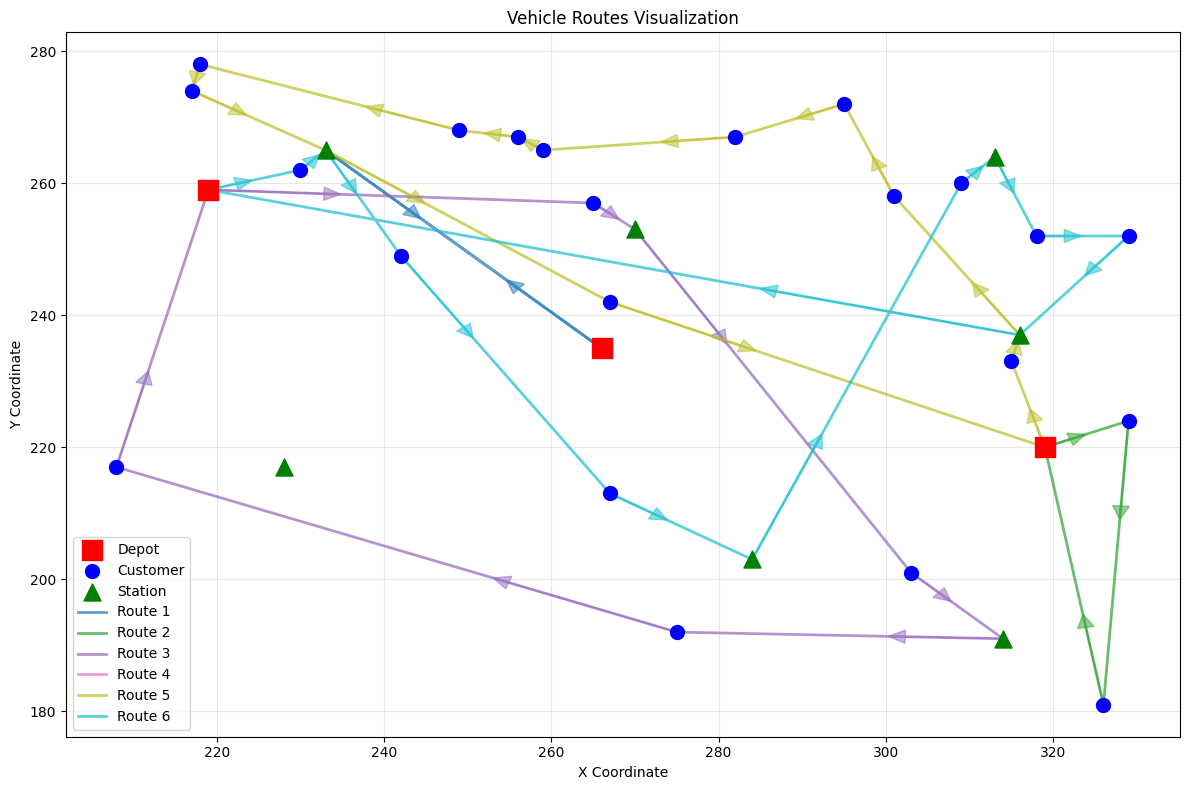

In [73]:
# Visualize the best solution
print("\n🏆 BEST SOLUTION VISUALIZATION:")
print(f"Chromosome: {result['best_chromosome']}")
print(f"Fitness: {result['best_fitness']:.4f}")
viz_route(result['best_chromosome'])


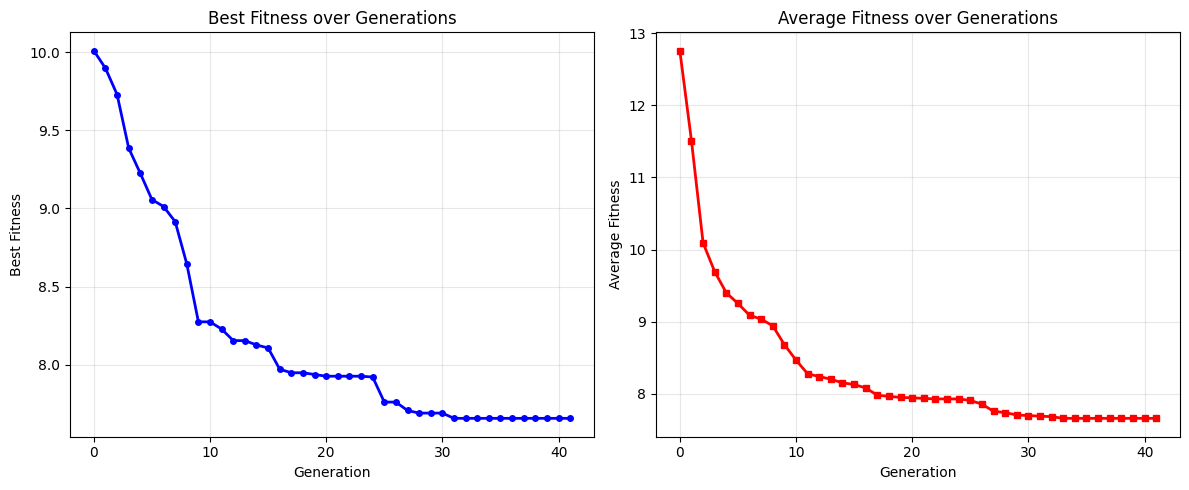


📈 Convergence Analysis:
Initial Best: 10.0084
Final Best: 7.6584
Total Improvement: 2.3499
Improvement %: 23.48%


In [74]:
# Plot convergence curve
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot best fitness over generations
plt.subplot(1, 2, 1)
plt.plot(result['history']['generation'], result['history']['best_fitness'], 'b-o', linewidth=2, markersize=4)
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Best Fitness over Generations')
plt.grid(True, alpha=0.3)

# Plot average fitness over generations
plt.subplot(1, 2, 2)
plt.plot(result['history']['generation'], result['history']['avg_fitness'], 'r-s', linewidth=2, markersize=4)
plt.xlabel('Generation')
plt.ylabel('Average Fitness')
plt.title('Average Fitness over Generations')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📈 Convergence Analysis:")
print(f"Initial Best: {result['history']['best_fitness'][0]:.4f}")
print(f"Final Best: {result['history']['best_fitness'][-1]:.4f}")
print(f"Total Improvement: {result['history']['best_fitness'][0] - result['history']['best_fitness'][-1]:.4f}")
print(f"Improvement %: {((result['history']['best_fitness'][0] - result['history']['best_fitness'][-1]) / result['history']['best_fitness'][0] * 100):.2f}%")


---

## Penjelasan Flow GA yang Sudah Diimplementasikan

### **Flow Lengkap:**

```
INITIALIZATION (Step 1-2)
├─ Generate initial population (10 chromosomes)
└─ Evaluate fitness untuk semua chromosomes

EVOLUTION LOOP (Step 3) - Repeat untuk 50 generasi:
│
├─ 3a. SELECTION (Tournament Selection)
│   ├─ Pilih parents = (pop_size - elite_size) / 2 = (10-2)/2 = 4 parents
│   └─ Menggunakan tournament size = 3
│
├─ 3b. CROSSOVER (BCRC Crossover)
│   ├─ 4 parents → 2 pasangan
│   ├─ Setiap pasangan: 80% chance di-crossover → 2 offspring
│   ├─ 20% chance tidak crossover → copy parents
│   └─ Total offspring = 4 chromosomes
│
├─ 3c. MUTATION (Inter-depot/Intra-depot)
│   ├─ Setiap offspring: 10% chance di-mutasi
│   └─ Tipe mutasi otomatis dipilih (border customer check)
│
├─ 3d. EVALUATE OFFSPRING
│   └─ Hitung fitness untuk 4 offspring baru
│
└─ 3e. REPLACEMENT (Elitism)
    ├─ Gabung: 10 old population + 4 offspring = 14 chromosomes
    ├─ Sort berdasarkan fitness (best to worst)
    ├─ Pilih top 10 terbaik → new population
    └─ Elite (2 terbaik) dijamin lolos jika memang terbaik

TERMINATION:
├─ Stop jika sudah 50 generasi, ATAU
└─ Stop jika tidak ada improvement selama 10 generasi berturut-turut
```

### **Penjelasan Parameter:**

1. **Population Size = 10**: Total individu dalam setiap generasi
2. **Elite Size = 2**: Top 2 individu terbaik dijamin lolos (20% elitism)
3. **Crossover Rate = 0.8**: 80% pasangan parents akan di-crossover
4. **Mutation Rate = 0.1**: 10% offspring akan dimutasi
5. **Tournament Size = 3**: Setiap tournament ambil 3 random, pilih yang terbaik

### **Kenapa Flow Ini Best Practice?**

✅ **Elitism**: Solusi terbaik tidak hilang  
✅ **Pressure Balance**: Tournament selection + elitism = eksplorasi & eksploitasi seimbang  
✅ **Diversity**: Mutation rate 10% menjaga keragaman populasi  
✅ **Convergence Detection**: Stop otomatis jika stuck  
✅ **Scalable**: Bisa adjust parameter sesuai kompleksitas problem
